In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import networkx as nx

from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree, to_dense_adj, convert
from torch_geometric.data import DataLoader, DenseDataLoader
from torch_geometric.nn import GNNExplainer, GCNConv
from torch_geometric.nn import global_mean_pool, GlobalAttention

from sklearn.cluster import KMeans, MeanShift, DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn import tree, linear_model

import scipy.cluster.hierarchy as hierarchy
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestCentroid

from torch_geometric.nn import GNNExplainer

from utilities import *
from heuristics import *
from activation_classifier import *

set_rc_params()

np.random.seed(3)
torch.manual_seed(3)

In [2]:
k = 10

path = "output/reddit/"
path_tsne = os.path.join(path, "TSNE")
path_pca = os.path.join(path, "PCA")
path_kmeans = os.path.join(path, f"{k}_KMeans")
path_hc = os.path.join(path, f"HC")
os.makedirs(path, exist_ok=True)
os.makedirs(path_tsne, exist_ok=True)
os.makedirs(path_pca, exist_ok=True)
os.makedirs(path_kmeans, exist_ok=True)
os.makedirs(path_hc, exist_ok=True)

batch_size = 20
graphs = load_real_data("Reddit_Binary")
train_loader, test_loader, full_loader = prepare_real_data(graphs, 0.8, batch_size)
labels = next(iter(full_loader)).y

model = Reddit_GCN(graphs.num_node_features, graphs.num_classes)


Dataset: REDDIT-BINARY(2000):
Number of graphs: 2000
Number of features: 1
Number of classes: 2

Data(edge_index=[2, 480], x=[218, 1], y=[1])
Number of nodes: 218
Number of edges: 480
Average node degree: 2.20
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True

Class split - Training 0: 792 1:808, Test 0: 208 1: 192


Epoch: 000, Train Loss: 0.69337, Test Loss: 0.68961, Train Acc: 0.50625, Test Acc: 0.48500
Epoch: 001, Train Loss: 0.66291, Test Loss: 0.57791, Train Acc: 0.64250, Test Acc: 0.68000
Epoch: 002, Train Loss: 0.59126, Test Loss: 0.56071, Train Acc: 0.68563, Test Acc: 0.70750
Epoch: 003, Train Loss: 0.59071, Test Loss: 0.58971, Train Acc: 0.68812, Test Acc: 0.68500
Epoch: 004, Train Loss: 0.58341, Test Loss: 0.55055, Train Acc: 0.68188, Test Acc: 0.71250
Epoch: 005, Train Loss: 0.57428, Test Loss: 0.57556, Train Acc: 0.68812, Test Acc: 0.71500
Epoch: 006, Train Loss: 0.57904, Test Loss: 0.55088, Train Acc: 0.67812, Test Acc: 0.70250
Epoch: 007, Train Loss: 0.56772, Test Loss: 0.53553, Train Acc: 0.69063, Test Acc: 0.70750
Epoch: 008, Train Loss: 0.56144, Test Loss: 0.56780, Train Acc: 0.70063, Test Acc: 0.71750
Epoch: 009, Train Loss: 0.55413, Test Loss: 0.53650, Train Acc: 0.68812, Test Acc: 0.71500
Epoch: 010, Train Loss: 0.55197, Test Loss: 0.52952, Train Acc: 0.69500, Test Acc: 0.71500

Epoch: 091, Train Loss: 0.34294, Test Loss: 0.36133, Train Acc: 0.83875, Test Acc: 0.82750
Epoch: 092, Train Loss: 0.34611, Test Loss: 0.29608, Train Acc: 0.86938, Test Acc: 0.87500
Epoch: 093, Train Loss: 0.33043, Test Loss: 0.28546, Train Acc: 0.87000, Test Acc: 0.87750
Epoch: 094, Train Loss: 0.33403, Test Loss: 0.29080, Train Acc: 0.86813, Test Acc: 0.88000
Epoch: 095, Train Loss: 0.33822, Test Loss: 0.31062, Train Acc: 0.86687, Test Acc: 0.86750
Epoch: 096, Train Loss: 0.35347, Test Loss: 0.30611, Train Acc: 0.87187, Test Acc: 0.86750
Epoch: 097, Train Loss: 0.33613, Test Loss: 0.27644, Train Acc: 0.87625, Test Acc: 0.89000
Epoch: 098, Train Loss: 0.32530, Test Loss: 0.29980, Train Acc: 0.86625, Test Acc: 0.86500
Epoch: 099, Train Loss: 0.35041, Test Loss: 0.31261, Train Acc: 0.84750, Test Acc: 0.88250
Epoch: 100, Train Loss: 0.32036, Test Loss: 0.29531, Train Acc: 0.85875, Test Acc: 0.86750
Epoch: 101, Train Loss: 0.34467, Test Loss: 0.28941, Train Acc: 0.86438, Test Acc: 0.87500

Epoch: 182, Train Loss: 0.29173, Test Loss: 0.26575, Train Acc: 0.88687, Test Acc: 0.89500
Epoch: 183, Train Loss: 0.29594, Test Loss: 0.26874, Train Acc: 0.89125, Test Acc: 0.88750
Epoch: 184, Train Loss: 0.29272, Test Loss: 0.27490, Train Acc: 0.89250, Test Acc: 0.90500
Epoch: 185, Train Loss: 0.28718, Test Loss: 0.25781, Train Acc: 0.89687, Test Acc: 0.89250
Epoch: 186, Train Loss: 0.28708, Test Loss: 0.28833, Train Acc: 0.87625, Test Acc: 0.87750
Epoch: 187, Train Loss: 0.29042, Test Loss: 0.25644, Train Acc: 0.89938, Test Acc: 0.91500
Epoch: 188, Train Loss: 0.28578, Test Loss: 0.26978, Train Acc: 0.89750, Test Acc: 0.89750
Epoch: 189, Train Loss: 0.28957, Test Loss: 0.26163, Train Acc: 0.89375, Test Acc: 0.89500
Epoch: 190, Train Loss: 0.30028, Test Loss: 0.26553, Train Acc: 0.90125, Test Acc: 0.90000
Epoch: 191, Train Loss: 0.28497, Test Loss: 0.23846, Train Acc: 0.89875, Test Acc: 0.91500
Epoch: 192, Train Loss: 0.30147, Test Loss: 0.27679, Train Acc: 0.90438, Test Acc: 0.90000

Epoch: 273, Train Loss: 0.26394, Test Loss: 0.25952, Train Acc: 0.90375, Test Acc: 0.91250
Epoch: 274, Train Loss: 0.26090, Test Loss: 0.23681, Train Acc: 0.89625, Test Acc: 0.91000
Epoch: 275, Train Loss: 0.28317, Test Loss: 0.30863, Train Acc: 0.88313, Test Acc: 0.87500
Epoch: 276, Train Loss: 0.26636, Test Loss: 0.27669, Train Acc: 0.89125, Test Acc: 0.90500
Epoch: 277, Train Loss: 0.27397, Test Loss: 0.26783, Train Acc: 0.89125, Test Acc: 0.90000
Epoch: 278, Train Loss: 0.26755, Test Loss: 0.27520, Train Acc: 0.89812, Test Acc: 0.89500
Epoch: 279, Train Loss: 0.26271, Test Loss: 0.25138, Train Acc: 0.89563, Test Acc: 0.89750
Epoch: 280, Train Loss: 0.27742, Test Loss: 0.27449, Train Acc: 0.89500, Test Acc: 0.89500
Epoch: 281, Train Loss: 0.27661, Test Loss: 0.23384, Train Acc: 0.90625, Test Acc: 0.90500
Epoch: 282, Train Loss: 0.26085, Test Loss: 0.29607, Train Acc: 0.87250, Test Acc: 0.87000
Epoch: 283, Train Loss: 0.27076, Test Loss: 0.25350, Train Acc: 0.89375, Test Acc: 0.90250

Epoch: 364, Train Loss: 0.30043, Test Loss: 0.25321, Train Acc: 0.88375, Test Acc: 0.89750
Epoch: 365, Train Loss: 0.27946, Test Loss: 0.29849, Train Acc: 0.87750, Test Acc: 0.87500
Epoch: 366, Train Loss: 0.26073, Test Loss: 0.26703, Train Acc: 0.88875, Test Acc: 0.88750
Epoch: 367, Train Loss: 0.27682, Test Loss: 0.28192, Train Acc: 0.90500, Test Acc: 0.91250
Epoch: 368, Train Loss: 0.25906, Test Loss: 0.24698, Train Acc: 0.90312, Test Acc: 0.89250
Epoch: 369, Train Loss: 0.25168, Test Loss: 0.31430, Train Acc: 0.88625, Test Acc: 0.89250
Epoch: 370, Train Loss: 0.26152, Test Loss: 0.23466, Train Acc: 0.89938, Test Acc: 0.90250
Epoch: 371, Train Loss: 0.25871, Test Loss: 0.28734, Train Acc: 0.88625, Test Acc: 0.87500
Epoch: 372, Train Loss: 0.25832, Test Loss: 0.24557, Train Acc: 0.90312, Test Acc: 0.90500
Epoch: 373, Train Loss: 0.25809, Test Loss: 0.24084, Train Acc: 0.90750, Test Acc: 0.91000
Epoch: 374, Train Loss: 0.24659, Test Loss: 0.23295, Train Acc: 0.90250, Test Acc: 0.92000

Epoch: 455, Train Loss: 0.24688, Test Loss: 0.24795, Train Acc: 0.90750, Test Acc: 0.90250
Epoch: 456, Train Loss: 0.24255, Test Loss: 0.25455, Train Acc: 0.90750, Test Acc: 0.92000
Epoch: 457, Train Loss: 0.24745, Test Loss: 0.26864, Train Acc: 0.89500, Test Acc: 0.89500
Epoch: 458, Train Loss: 0.24607, Test Loss: 0.23230, Train Acc: 0.89687, Test Acc: 0.91750
Epoch: 459, Train Loss: 0.25151, Test Loss: 0.25371, Train Acc: 0.90312, Test Acc: 0.90000
Epoch: 460, Train Loss: 0.24384, Test Loss: 0.24444, Train Acc: 0.91125, Test Acc: 0.89500
Epoch: 461, Train Loss: 0.24795, Test Loss: 0.27205, Train Acc: 0.89062, Test Acc: 0.89250
Epoch: 462, Train Loss: 0.25573, Test Loss: 0.25625, Train Acc: 0.89500, Test Acc: 0.92000
Epoch: 463, Train Loss: 0.24697, Test Loss: 0.25555, Train Acc: 0.90438, Test Acc: 0.91000
Epoch: 464, Train Loss: 0.25770, Test Loss: 0.22905, Train Acc: 0.89750, Test Acc: 0.91000
Epoch: 465, Train Loss: 0.25598, Test Loss: 0.27532, Train Acc: 0.88000, Test Acc: 0.89000

Epoch: 546, Train Loss: 0.24676, Test Loss: 0.32553, Train Acc: 0.89312, Test Acc: 0.87000
Epoch: 547, Train Loss: 0.25969, Test Loss: 0.23465, Train Acc: 0.91000, Test Acc: 0.91250
Epoch: 548, Train Loss: 0.24020, Test Loss: 0.24702, Train Acc: 0.90063, Test Acc: 0.92000
Epoch: 549, Train Loss: 0.24064, Test Loss: 0.27719, Train Acc: 0.89812, Test Acc: 0.89000
Epoch: 550, Train Loss: 0.24539, Test Loss: 0.23571, Train Acc: 0.90375, Test Acc: 0.92250
Epoch: 551, Train Loss: 0.23871, Test Loss: 0.23637, Train Acc: 0.90625, Test Acc: 0.91000
Epoch: 552, Train Loss: 0.24333, Test Loss: 0.23681, Train Acc: 0.90500, Test Acc: 0.91750
Epoch: 553, Train Loss: 0.24497, Test Loss: 0.23787, Train Acc: 0.90812, Test Acc: 0.90750
Epoch: 554, Train Loss: 0.24097, Test Loss: 0.26254, Train Acc: 0.88938, Test Acc: 0.89000
Epoch: 555, Train Loss: 0.24443, Test Loss: 0.25693, Train Acc: 0.89438, Test Acc: 0.88500
Epoch: 556, Train Loss: 0.24228, Test Loss: 0.23588, Train Acc: 0.91063, Test Acc: 0.91500

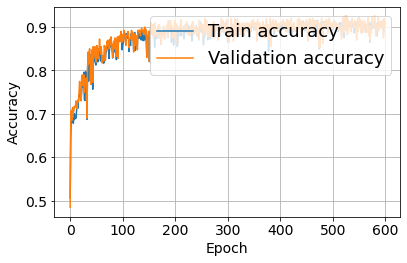

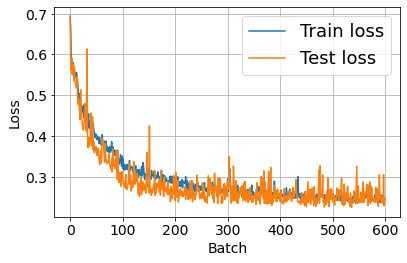

In [3]:
load_pretrained = False

if load_pretrained:
    print("Loading pretrained model...")
    model.load_state_dict(torch.load(os.path.join(path, "model.pkl")))
    model.eval()
    
    model = register_hooks(model)
    print(len(full_loader))
    for data in full_loader:
        print(len(data.x))
        out = model(data.x, data.edge_index, data.batch)
        
    with open(os.path.join(path, "activations.txt"), 'wb') as file:
        pickle.dump(activation_list, file)
    
    with open(os.path.join(path, "activations.txt"), 'rb') as file:
        activation_list = pickle.loads(file.read())

else:
#     model.apply(weights_init)
    train_graph_class(model, train_loader, test_loader, full_loader, 600, 0.01, path)

In [4]:
# want to get rid of convolutional layers
keys_to_pop = []
for key in activation_list:
    if key.find("conv") != -1:
        keys_to_pop.append(key)

for key in keys_to_pop:
    activation_list.pop(key)
    
print("Remaining Keys:")
for key in activation_list:
    print(key)

Remaining Keys:
pool0
pool1
pool2
pool3
lin


# TSNE

pool0
(2000, 40)


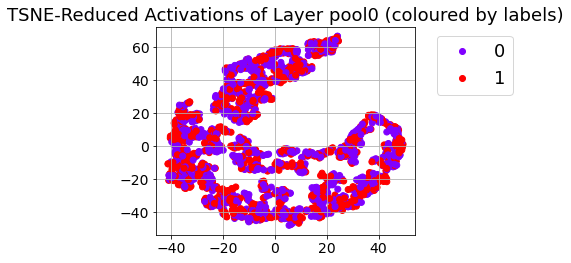

pool1
(2000, 40)


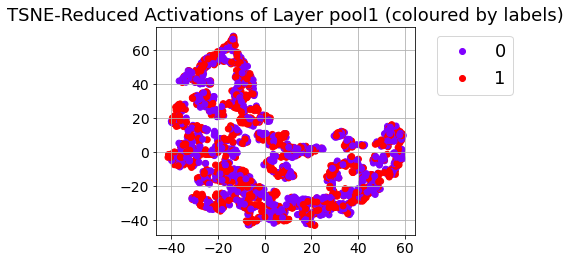

pool2
(2000, 40)


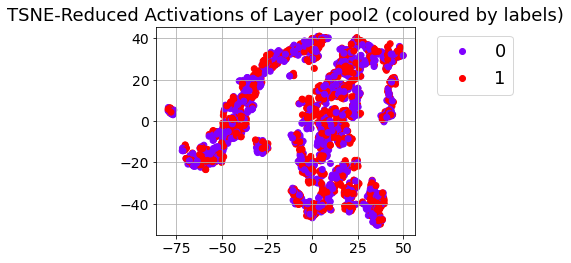

pool3
(2000, 40)


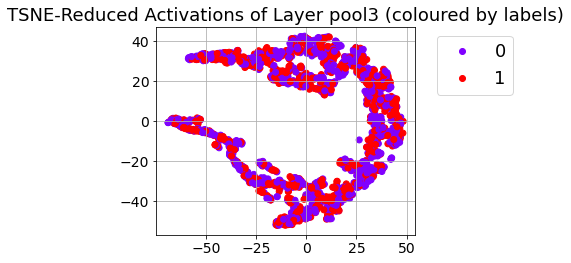

lin


In [5]:
# TSNE conversion
tsne_models = []
tsne_data = []
for layer_num, key in enumerate(activation_list):
    print(key)
    if key.find("pool") == -1:
        continue
    
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    print(activation.shape)
    tsne_model = TSNE(n_components=2)
    d = tsne_model.fit_transform(activation)
    plot_activation_space(d, labels, "TSNE-Reduced", key, path_tsne, "(coloured by labels)")
    
    tsne_models.append(tsne_model)
    tsne_data.append(d)

# PCA

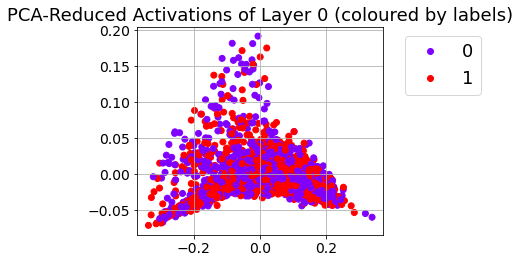

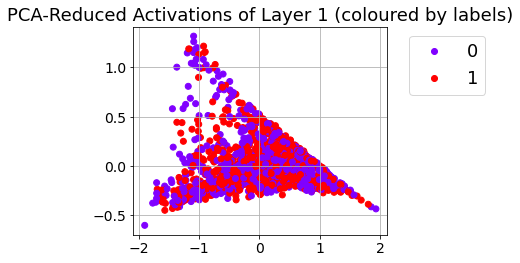

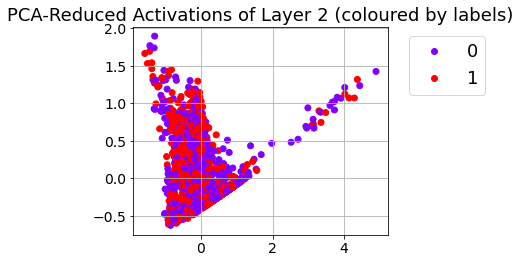

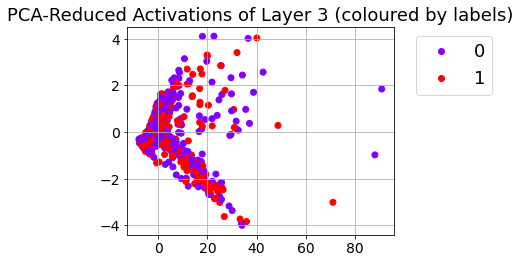

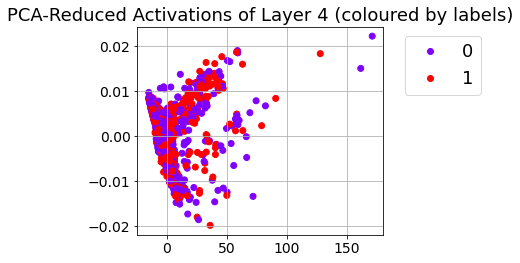

In [6]:
# PCA conversion
pca_models = []
pca_data = []
for layer_num, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    pca_model = PCA(n_components=2)
    d = pca_model.fit_transform(activation)
    plot_activation_space(d, labels, "PCA-Reduced", layer_num, path_pca, "(coloured by labels)")
    
    pca_models.append(pca_model)
    pca_data.append(d)

# UMAP

# Perform KMeans Clustering

/Users/luciecharlottemagister/Documents/Cambridge/Coursework/MPhil/src/k_clustering/clustering_env/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.canvas.print_figure(bytes_io, **kw)


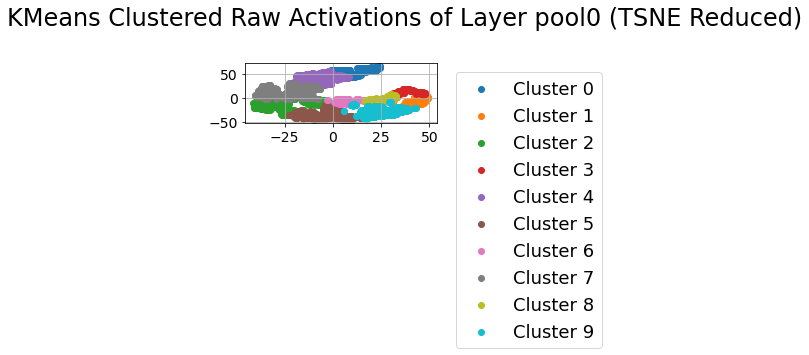

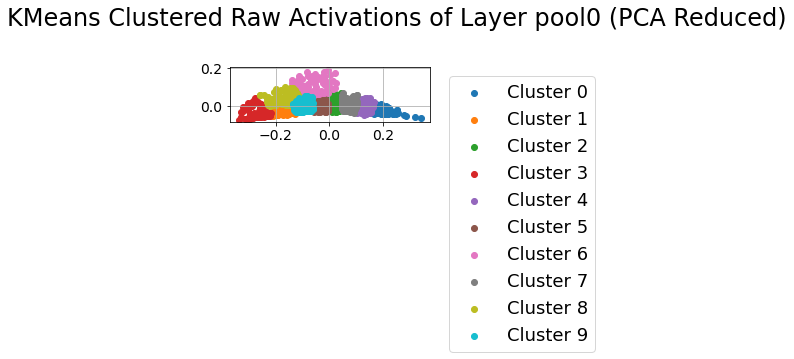

/Users/luciecharlottemagister/Documents/Cambridge/Coursework/MPhil/src/k_clustering/utilities.py:269: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.savefig(os.path.join(path, f"{layer_num}layer_{clustering_type}_{views}view.png"))
/Users/luciecharlottemagister/Documents/Cambridge/Coursework/MPhil/src/k_clustering/clustering_env/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.canvas.print_figure(bytes_io, **kw)


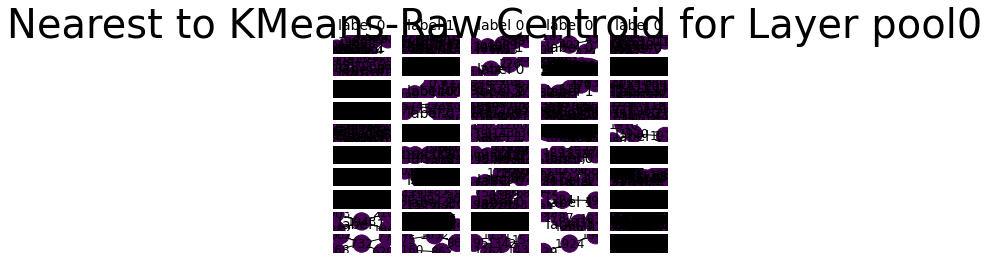

/Users/luciecharlottemagister/Documents/Cambridge/Coursework/MPhil/src/k_clustering/clustering_env/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.canvas.print_figure(bytes_io, **kw)


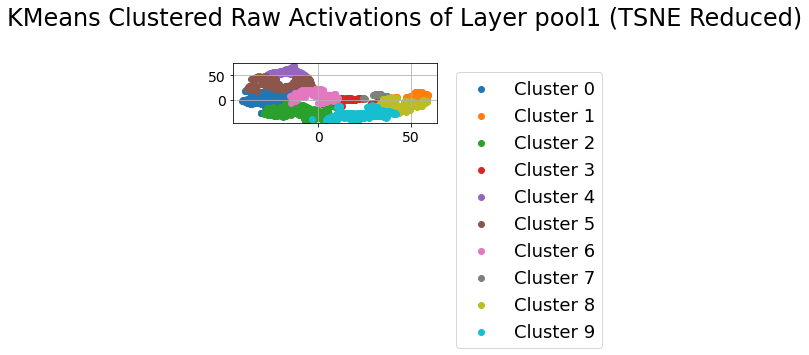

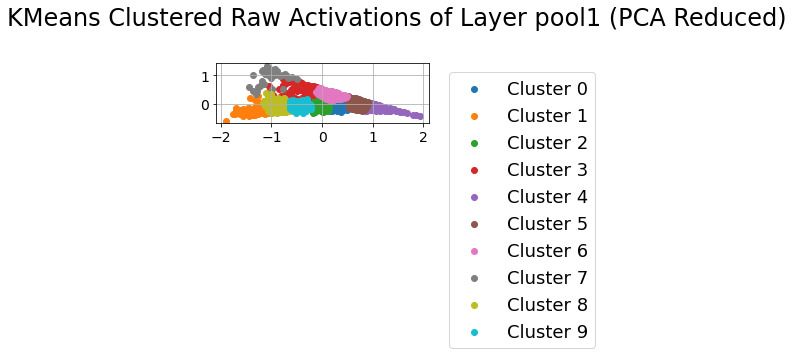

/Users/luciecharlottemagister/Documents/Cambridge/Coursework/MPhil/src/k_clustering/utilities.py:269: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.savefig(os.path.join(path, f"{layer_num}layer_{clustering_type}_{views}view.png"))
/Users/luciecharlottemagister/Documents/Cambridge/Coursework/MPhil/src/k_clustering/clustering_env/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.canvas.print_figure(bytes_io, **kw)


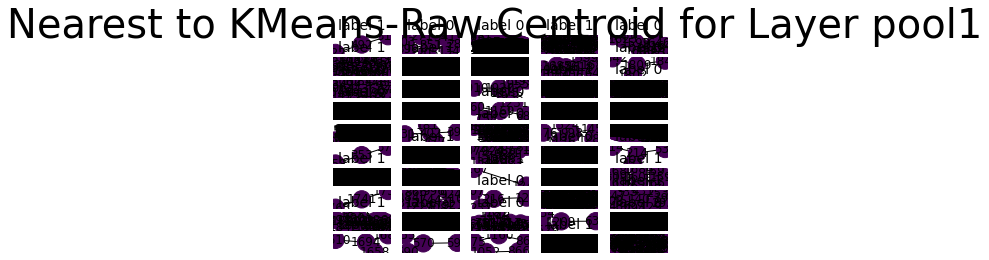

/Users/luciecharlottemagister/Documents/Cambridge/Coursework/MPhil/src/k_clustering/clustering_env/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.canvas.print_figure(bytes_io, **kw)


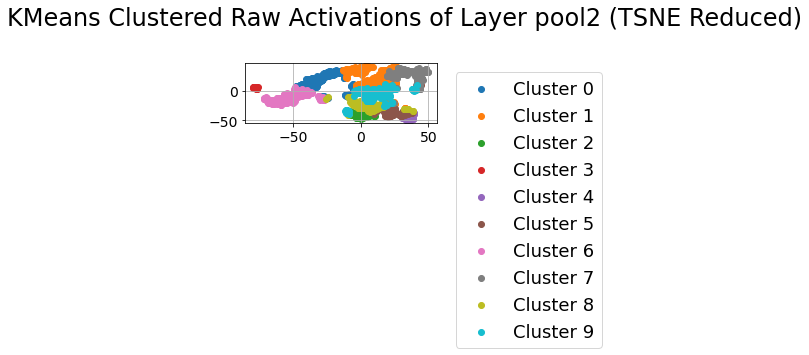

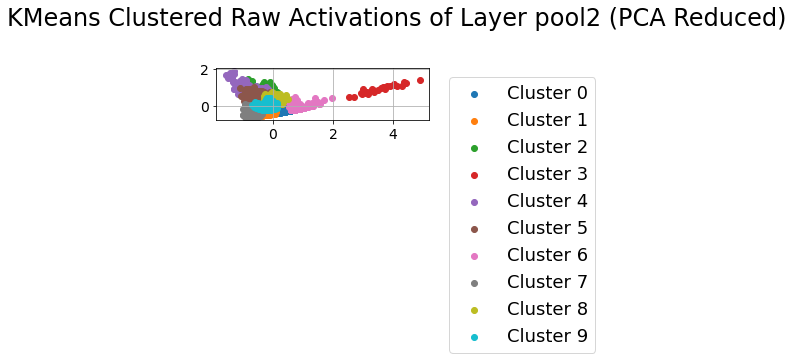

/Users/luciecharlottemagister/Documents/Cambridge/Coursework/MPhil/src/k_clustering/utilities.py:269: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.savefig(os.path.join(path, f"{layer_num}layer_{clustering_type}_{views}view.png"))
/Users/luciecharlottemagister/Documents/Cambridge/Coursework/MPhil/src/k_clustering/clustering_env/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.canvas.print_figure(bytes_io, **kw)


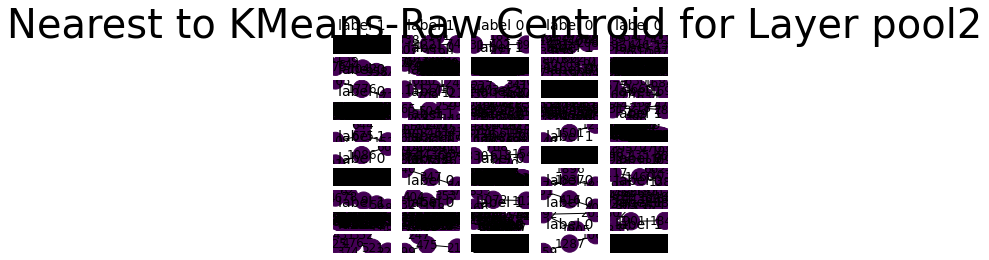

/Users/luciecharlottemagister/Documents/Cambridge/Coursework/MPhil/src/k_clustering/clustering_env/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.canvas.print_figure(bytes_io, **kw)


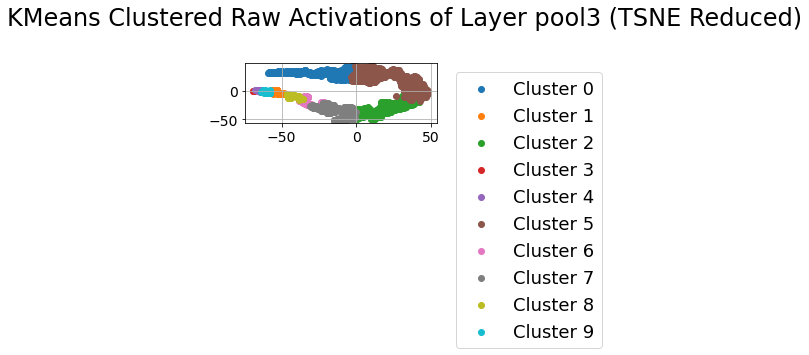

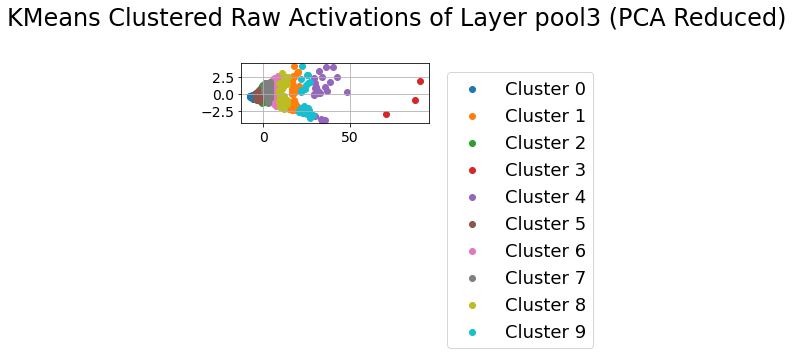

/Users/luciecharlottemagister/Documents/Cambridge/Coursework/MPhil/src/k_clustering/utilities.py:269: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.savefig(os.path.join(path, f"{layer_num}layer_{clustering_type}_{views}view.png"))
/Users/luciecharlottemagister/Documents/Cambridge/Coursework/MPhil/src/k_clustering/clustering_env/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.canvas.print_figure(bytes_io, **kw)


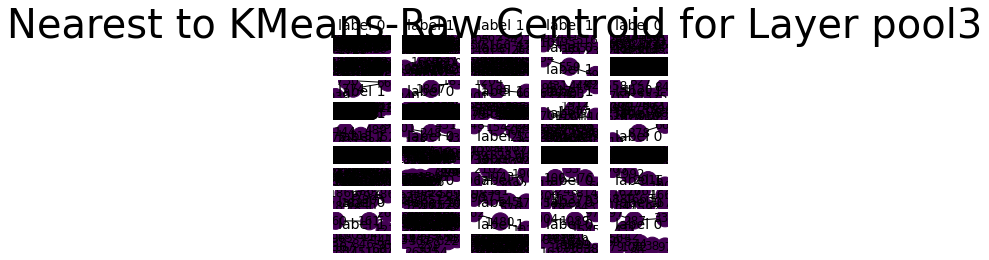

IndexError: list index out of range

In [7]:
num_nodes_view = 5
num_expansions = 2

dataset_data = next(iter(full_loader))
edges = dataset_data.edge_index.transpose(0, 1).detach().numpy()
y = dataset_data.y

raw_sample_graphs = []
raw_sample_feat = []
raw_kmeans_models = []
for layer_num, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    kmeans_model = KMeans(n_clusters=k, random_state=0)
    kmeans_model = kmeans_model.fit(activation)
    pred_labels = kmeans_model.predict(activation)
        
    plot_clusters(tsne_data[layer_num], pred_labels, "KMeans", k, key, path_kmeans, "Raw", "_TSNE", "(TSNE Reduced)")
    plot_clusters(pca_data[layer_num], pred_labels, "KMeans", k, key, path_kmeans, "Raw", "_PCA", "(PCA Reduced)")
    sample_graphs, sample_feat = plot_samples(kmeans_model, activation, y, key, k, "KMeans-Raw", num_nodes_view, edges, num_expansions, path_kmeans, dataset_data)
    
    raw_sample_graphs.append(sample_graphs)
    raw_sample_feat.append(sample_feat)
    raw_kmeans_models.append(kmeans_model)
    

In [ ]:
tsne_sample_graphs = []
tsne_sample_feat = []
tsne_kmeans_models = []
for layer_num, (key, item) in enumerate(zip(activation_list, tsne_data)):
    kmeans_model = KMeans(n_clusters=k, random_state=0)
    kmeans_model = kmeans_model.fit(item)
    pred_labels = kmeans_model.predict(item)
        
    plot_clusters(item, pred_labels, "KMeans", k, key, path_kmeans, "TSNE")
    sample_graphs, sample_feat = plot_samples(kmeans_model, item, y, key, k, "KMeans-TSNE", num_nodes_view, edges, num_expansions, path_kmeans, dataset_data)
    
    tsne_sample_graphs.append(sample_graphs)
    tsne_sample_feat.append(sample_feat)
    tsne_kmeans_models.append(kmeans_model)
    
pca_sample_graphs = []
pca_sample_feat = []
pca_kmeans_models = []
for key, item in zip(activation_list, pca_data):
    kmeans_model = KMeans(n_clusters=k, random_state=0)
    kmeans_model = kmeans_model.fit(item)
    pred_labels = kmeans_model.predict(item)
        
    plot_clusters(item, pred_labels, "KMeans", k, key, path_kmeans, "PCA")
    sample_graphs, sample_feat = plot_samples(kmeans_model, item, y, key, k, "KMeans-PCA", num_nodes_view, edges, num_expansions, path_kmeans, dataset_data)
    
    pca_sample_graphs.append(sample_graphs)
    pca_sample_feat.append(sample_feat)
    pca_kmeans_models.append(kmeans_model)

In [ ]:
mutag_heuristics = Mutag_Heuristics()

for layer_num, (key, sample, feat) in enumerate(zip(activation_list, raw_sample_graphs, raw_sample_feat)):
    mutag_heuristics.plot_heuristics_table(sample, feat, key, "KMeans-Raw", path_kmeans)
    
for layer_num, (key, sample, feat) in enumerate(zip(activation_list, tsne_sample_graphs, tsne_sample_feat)):
    mutag_heuristics.plot_heuristics_table(sample, feat, key, "KMeans-TSNE", path_kmeans)
    
for layer_num, (key, sample, feat) in enumerate(zip(activation_list, pca_sample_graphs, pca_sample_feat)):
    mutag_heuristics.plot_heuristics_table(sample, feat, key, "KMeans-PCA", path_kmeans)
    

# Perform Hierarchical Clustering

In [ ]:
for layer_num, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    plot_dendrogram(activation, "Raw", layer_num, path_hc)

In [ ]:
raw_n_clusters = [3, 3, 18, 20]

raw_sample_graphs = []
raw_sample_feat = []
raw_hc_models = []
for layer_num, (key, n) in enumerate(zip(activation_list, raw_n_clusters)):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    hc = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='average')
    pred_labels = hc.fit_predict(activation)
    
    d = (activation, pred_labels)
    plot_clusters(tsne_data[layer_num], pred_labels, "HC", n, layer_num, path_hc, "Raw", "_TSNE", "(TSNE Reduced)")
    plot_clusters(pca_data[layer_num], pred_labels, "HC", n, layer_num, path_hc, "Raw", "_PCA", "(PCA Reduced)")
    sample_graphs, sample_feat = plot_samples(hc, d, y, layer_num, n, "HC-Raw", num_nodes_view, edges, num_expansions, path_hc, dataset_data)
    
    raw_sample_graphs.append(sample_graphs)
    raw_sample_feat.append(sample_feat)
    raw_hc_models.append(hc)

In [ ]:
for layer_num, item in enumerate(tsne_data):
    plot_dendrogram(item, "TSNE", layer_num, path_hc)

In [ ]:
tsne_n_clusters = [7, 12, 20, 20]

tsne_sample_graphs = []
tsne_sample_feat = []
tsne_hc_models = []
for layer_num, (item, n) in enumerate(zip(tsne_data, tsne_n_clusters)):
    hc = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='average')
    pred_labels = hc.fit_predict(item)
    
    d = (item, pred_labels)
    plot_clusters(item, pred_labels, "HC", n, layer_num, path_hc, "TSNE")
    sample_graphs, sample_feat = plot_samples(hc, d, y, layer_num, n, "HC-TSNE", num_nodes_view, edges, num_expansions, path_hc, dataset_data)
    
    tsne_sample_graphs.append(sample_graphs)
    tsne_sample_feat.append(sample_feat)
    tsne_hc_models.append(hc)

In [ ]:
for layer_num, item in enumerate(pca_data):
    plot_dendrogram(item, "PCA", layer_num, path_hc)

In [ ]:
pca_n_clusters = [7, 12, 20, 20]

pca_sample_graphs = []
pca_sample_feat = []
pca_hc_models = []
for layer_num, (item, n) in enumerate(zip(pca_data, pca_n_clusters)):
    hc = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='average')
    pred_labels = hc.fit_predict(item)
    
    d = (item, pred_labels)
    plot_clusters(item, pred_labels, "HC", n, layer_num, path_hc, "PCA")
    sample_graphs, sample_feat = plot_samples(hc, d, y, layer_num, n, "HC-PCA", num_nodes_view, edges, num_expansions, path_hc, dataset_data)
    
    pca_sample_graphs.append(sample_graphs)
    pca_sample_feat.append(sample_feat)
    pca_hc_models.append(hc)

In [ ]:
for layer_num, (sample, feat) in enumerate(zip(raw_sample_graphs, raw_sample_feat)):
    mutag_heuristics.plot_heuristics_table(sample, feat, layer_num, "HC-RAW", path_kmeans)
    
for layer_num, (sample, feat) in enumerate(zip(tsne_sample_graphs, tsne_sample_feat)):
    mutag_heuristics.plot_heuristics_table(sample, feat, layer_num, "HC-TSNE", path_hc)
    
for layer_num, (sample, feat) in enumerate(zip(pca_sample_graphs, pca_sample_feat)):
    mutag_heuristics.plot_heuristics_table(sample, feat, layer_num, "HC-PCA", path_hc)

# Activation to Concept to Class

In [ ]:
classifier_str = "decision_tree"

completeness_scores = []

for i, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    activation_cls = ActivationClassifier(activation, raw_kmeans_models[i], classifier_str, graphs, dataset_data.y, edges, i, True)
    
    d = ["Kmeans", "Raw", str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(path_kmeans, i, k, "Raw")
    
for i, item in enumerate(tsne_data):
    activation_cls = ActivationClassifier(item, tsne_kmeans_models[i], classifier_str, graphs, dataset_data.y, edges, i, True)
    
    d = ["Kmeans", "TSNE-Reduced", str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(path_kmeans, i, k, "TSNE")
    
for i, item in enumerate(pca_data):
    activation_cls = ActivationClassifier(item, pca_kmeans_models[i], classifier_str, graphs, dataset_data.y, edges, i, True)
    
    d = ["Kmeans", "PCA-Reduced", str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(path_kmeans, i, k, "PCA")
    
plot_completeness_table("Kmeans", "Decision Tree", completeness_scores, path_kmeans)
    

In [ ]:
classifier_str = "logistic_regression"

completeness_scores = []

for i, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    activation_cls = ActivationClassifier(activation, raw_kmeans_models[i], classifier_str, graphs, dataset_data.y, edges, i, True)
    
    d = ["Kmeans", "Raw", str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(path_kmeans, i, k, "Raw")
    
for i, item in enumerate(tsne_data):
    activation_cls = ActivationClassifier(item, tsne_kmeans_models[i], classifier_str, graphs, dataset_data.y, edges, i, True)
    
    d = ["Kmeans", "TSNE-Reduced", str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(path_kmeans, i, k, "TSNE")
    
for i, item in enumerate(pca_data):
    activation_cls = ActivationClassifier(item, pca_kmeans_models[i], classifier_str, graphs, dataset_data.y, edges, i, True)
    
    d = ["Kmeans", "PCA-Reduced", str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(path_kmeans, i, k, "PCA")
    
plot_completeness_table("Kmeans", "Logistic Regression", completeness_scores, path_kmeans)
    

In [ ]:
classifier_str = "decision_tree"

completeness_scores = []

for i, (key, n) in enumerate(zip(activation_list, raw_n_clusters)):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    activation_cls = ActivationClassifier(activation, raw_hc_models[i], classifier_str, graphs, dataset_data.y, edges, i, True)
    
    d = ["HC", "Raw", str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(path_hc, i, n, "Raw")
    
for i, (item, n) in enumerate(zip(tsne_data, tsne_n_clusters)):
    activation_cls = ActivationClassifier(item, tsne_hc_models[i], classifier_str, graphs, dataset_data.y, edges, i, True)
    
    d = ["HC", "TSNE-Reduced", str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(path_hc, i, n, "PCA")
    
for i, (item, n) in enumerate(zip(pca_data, pca_n_clusters)):
    activation_cls = ActivationClassifier(item, pca_hc_models[i], classifier_str, graphs, dataset_data.y, edges, i, True)
    
    d = ["HC", "PCA-Reduced", str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(path_hc, i, n, "PCA")

plot_completeness_table("HC", "Decision Tree", completeness_scores, path_hc)

In [ ]:
classifier_str = "logistic_regression"

completeness_scores = []

for i, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    activation_cls = ActivationClassifier(activation, raw_hc_models[i], classifier_str, graphs, dataset_data.y, edges, i, True)
    
    d = ["HC", "Raw", str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(path_hc, i, n, "Raw")
    
for i, item in enumerate(tsne_data):
    activation_cls = ActivationClassifier(item, tsne_hc_models[i], classifier_str, graphs, dataset_data.y, edges, i, True)
    
    d = ["HC", "TSNE-Reduced", str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(path_hc, i, n, "TSNE")
    
for i, item in enumerate(pca_data):
    activation_cls = ActivationClassifier(item, pca_hc_models[i], classifier_str, graphs, dataset_data.y, edges, i, True)
    
    d = ["HC", "PCA-Reduced", str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(path_hc, i, n, "PCA")

plot_completeness_table("HC", "Logistic Regression", completeness_scores, path_hc)
    

# Graph Similarity Score

In [ ]:
graph_scores = []
view = 3
max_nodes = 15

for i, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    distances = get_node_distances(raw_kmeans_models[i], activation)
    
    for k_idx in range(k):        
        top_indices = np.argsort(distances[:, k_idx])[::][:view]
        top_graphs, _, _ = get_top_subgraphs(top_indices, dataset_data.y, edges, num_expansions)
        
        score = calc_graph_similarity(top_graphs, max_nodes, view)
        print(score)
        
        d = ["KMeans", "Raw", str(i), str(k_idx), str(score)]
        graph_scores.append(d)
        
    plot_samples(raw_kmeans_models[i], activation, y, i, n, "KMeans-Raw", view, edges, num_expansions, path_hc, dataset_data)
        
        
for i, item in enumerate(tsne_data): 
    distances = get_node_distances(tsne_kmeans_models[i], item)
    
    for k_idx in range(k):
        top_indices = np.argsort(distances[:, k_idx])[::][:view]
        top_graphs, _, _ = get_top_subgraphs(top_indices, dataset_data.y, edges, num_expansions)
        
        score = calc_graph_similarity(top_graphs, max_nodes, view)
        print(score)
        
        d = ["KMeans", "TSNE", str(i), str(k_idx), str(score)]
        graph_scores.append(d)
        
    plot_samples(tsne_kmeans_models[i], item, dataset_data.y, i, n, "KMeans-TSNE", view, edges, num_expansions, path_hc, dataset_data)
        

        
for i, item in enumerate(pca_data):
    distances = get_node_distances(pca_kmeans_models[i], item)

    for k_idx in range(k):
        top_indices = np.argsort(distances[:, k_idx])[::][:view]
        top_graphs, _, _ = get_top_subgraphs(top_indices, dataset_data.y, edges, num_expansions)
        
        score = calc_graph_similarity(top_graphs, max_nodes, view)
        print(score)
        
        d = ["KMeans", "PCA", str(i), str(k_idx), str(score)]
        graph_scores.append(d)
        
    plot_samples(pca_kmeans_models[i], item, dataset_data.y, i, n, "KMeans-PCA", view, edges, num_expansions, path_hc, dataset_data)
        
    
plot_graph_similarity_table("HC", graph_scores, path_hc)
    

In [ ]:
graph_scores = []
view = 3
max_nodes = 15

for i, (key, n) in enumerate(zip(activation_list, raw_n_clusters)):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    pred_labels = raw_hc_models[i].fit_predict(activation)
    d_item = (activation, pred_labels)
    distances = get_node_distances(raw_hc_models[i], d_item)
    
    for k_idx in range(n):        
        top_indices = np.argsort(distances[k_idx])[::][:view]
        top_graphs, _, _ = get_top_subgraphs(top_indices, dataset_data.y, edges, num_expansions)
        
        score = calc_graph_similarity(top_graphs, max_nodes, view)
        print(score)
        
        d = ["HC", "Raw", str(i), str(k_idx), str(score)]
        graph_scores.append(d)
        
    plot_samples(raw_hc_models[i], d_item, y, i, n, "HC-Raw", view, edges, num_expansions, path_hc, dataset_data)
        
        
for i, (item, n) in enumerate(zip(tsne_data, tsne_n_clusters)): 
    pred_labels = tsne_hc_models[i].fit_predict(item)
    d_item = (item, pred_labels)
    distances = get_node_distances(tsne_hc_models[i], d_item)
    
    for k_idx in range(n):
        top_indices = np.argsort(distances[k_idx])[::][:view]
        top_graphs, _, _ = get_top_subgraphs(top_indices, dataset_data.y, edges, num_expansions)
        
        score = calc_graph_similarity(top_graphs, max_nodes, view)
        print(score)
        
        d = ["HC", "TSNE", str(i), str(k_idx), str(score)]
        graph_scores.append(d)
        
    plot_samples(tsne_hc_models[i], d_item, y, i, n, "HC-TSNE", view, edges, num_expansions, path_hc, dataset_data)
        

        
for i, (item, n) in enumerate(zip(pca_data, pca_n_clusters)):
    pred_labels = pca_hc_models[i].fit_predict(item)
    d_item = (item, pred_labels)
    distances = get_node_distances(pca_hc_models[i], d_item)

    for k_idx in range(n):
        top_indices = np.argsort(distances[k_idx])[::][:view]
        top_graphs, _, _ = get_top_subgraphs(top_indices, dataset_data.y, edges, num_expansions)
        
        score = calc_graph_similarity(top_graphs, max_nodes, view)
        print(score)
        
        d = ["HC", "PCA", str(i), str(k_idx), str(score)]
        graph_scores.append(d)
        
    plot_samples(pca_hc_models[i], d_item, y, i, n, "HC-PCA", view, edges, num_expansions, path_hc, dataset_data)
        
    
plot_graph_similarity_table("HC", graph_scores, path_hc)
    

In [ ]:
color_map = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]

g1 = nx.Graph()
g1.add_edge(0, 1)
g1.add_edge(1, 2)
g1.add_edge(2, 3)
g1.add_edge(3, 4)
g1.add_edge(4, 5)
g1.add_edge(5, 6)
g1.add_edge(6, 7)
g1.add_edge(7, 8)
g1.add_edge(8, 9)
g1.add_edge(9, 10)
g1.add_edge(10, 11)
g1.add_edge(11, 12)
g1.add_edge(12, 13)

nx.draw(g1, node_color=color_map, with_labels=True)
plt.show()

# GNNExplainer

In [ ]:
# node_idx = 572

# # convert to edge format
# edges = edge_list.transpose(0, 1).t().contiguous()

# explainer = GNNExplainer2(model, epochs=200, return_type='log_prob', log=True)
# node_feat_mask, edge_mask = explainer.explain_node(node_idx, node_data_x, edges)

In [ ]:
# ax, G = explainer.visualize_subgraph(node_idx, edges, edge_mask, y=node_data_y, threshold=0.8)
# plt.show()

In [ ]:
# # 1) get 3 closest nodes of a cluster
# dataset_data = next(iter(full_loader))
# edges = dataset_data.edge_index.transpose(0, 1).detach().numpy()

# def get_top_graphs(graphs, top_indices):    
#     top_graphs = []
#     color_maps = []
#     graph_labels = []
        
#     for idx in top_indices:
#         graph_data = graphs[int(idx)]
#         new_G = nx.Graph()
#         new_G.add_edges_from(graph_data.edge_index.transpose(0, 1).numpy())
#         top_graphs.append(new_G)
        
#         color_map = []
#         for node, attribute in zip(new_G, graph_data.x.numpy()):
#             color_idx = np.argmax(attribute, axis=0)
#             color_map.append(color_idx)
            
#         color_maps.append(color_map)
        
#         graph_labels.append(graph_data.y)
            
#     return top_graphs, color_maps, graph_labels


# def plot_samples(graphs, clustering_model, layer, data, clustering_type, output):
#     num_nodes_view = 5
    
#     fig, axes = plt.subplots(k, num_nodes_view, figsize=(30,30))
#     fig.suptitle(f'Nearest to {clustering_type} Centroid for Layer {layer}', fontsize=40)

#     l = list(range(0, k))

#     for i, ax_list in zip(l, axes):        
#         # get top graphs
#         distances = clustering_model.transform(data)[:, i]
#         top_indices = np.argsort(distances)[::][:num_nodes_view]
#         top_graphs, color_maps, graph_labels = get_top_graphs(graphs, top_indices)
        
#         for ax, new_G, color_map, g_label in zip(ax_list, top_graphs, color_maps, graph_labels):
#             nx.draw(new_G, node_color=color_map, with_labels=True, ax=ax)
#             ax.set_title(f"label {g_label}", fontsize=14)
            
#     plt.savefig(os.path.join(path, f"{output}.png"))
#     plt.show()

In [ ]:
# class ActivationClassifier:
#     def __init__(self, tsne_data, clustering_model, classifier_type, x, y, edge_list, layer):
#         self.tsne_data = tsne_data
#         self.clustering_model = clustering_model
#         self.classifier_type = classifier_type
#         self.x = x.detach().numpy()
#         self.y = y.detach().numpy()
#         self.edge_list = edge_list
#         self.layer = layer
        
#         self.classifier, self.accuracy = self._train_classifier()
        
        
#     def _train_classifier(self):
#         concepts = []
#         for node_idx in range(len(node_data_x)):
#             concepts.append(self.activation_to_concept(node_idx))
          
#         if self.classifier_type == 'decision_tree':
#             classifier = tree.DecisionTreeClassifier()
#             classifier = classifier.fit(concepts, self.y)
#         elif self.classifier_type == 'linear_regression':
#             classifier = linear_model.LinearRegression()
#             classifier = classifier.fit(concepts, self.y)
        
#         # decision tree accuracy
#         accuracy = classifier.score(concepts, self.y)

#         return classifier, accuracy
    
    
#     def get_classifier_accuracy(self):
#         return self.accuracy
    

#     def _activation_to_cluster(self, node):
#         # apply tsne
#         if isinstance(self.clustering_model, KMeans):
#             activation = tsne_data[self.layer][node]
#             activation = activation.reshape((1, 2))
#             cluster = self.clustering_model.predict(activation)
            
#         elif isinstance(self.clustering_model, AgglomerativeClustering):
#             cluster = np.array([y_hc[node]])

#         return cluster

    
#     def _cluster_to_concept(self, cluster):
#         concept = cluster

#         return concept


#     def activation_to_concept(self, node):
#         # get cluster for node
#         cluster = self._activation_to_cluster(node)

#         # return cluster number as substitute of concept
#         concept = self._cluster_to_concept(cluster)

#         return concept

    
#     def concept_to_class(self, concept):
#         concept = concept.reshape(1, -1)
#         pred = self.classifier.predict(concept)

#         return pred

In [ ]:
# # get data
# # node_data_x = torch.from_numpy(features).float()
# # node_data_y = torch.from_numpy(labels)
# # edge_list = torch.from_numpy(edges).transpose(0, 1)

# temp = next(iter(full_loader))

# node_data_x = temp.x
# node_data_y = temp.y
# edge_list = temp.edge_index.transpose(0, 1)

# # vars
# chosen_layer = len(activation_list) - 1
# KmeansActivationCls = ActivationClassifier(tsne_data, kmeans_models[chosen_layer], 'decision_tree', node_data_x, node_data_y, edge_list, chosen_layer)

# print("Decision Tree Accuracy: ", KmeansActivationCls.get_decision_tree_accuracy())

# # activation to concept
# node_idx = 224
# concept = KmeansActivationCls.activation_to_concept(node_idx)
# print("Predicted concept is: ", concept)

# cls = KmeansActivationCls.concept_to_class(concept)
# print("Predicted class is: ", cls ," where real one is: ", node_data_y[node_idx])